In [1]:
%matplotlib inline
import cv2
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import numpy as np 
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot

2.3.0


In [2]:
import sys

import pandas as pd
pd.set_option('display.float_format','{:.4f}'.format)
from SauvolaDocBin.dataUtils import collect_binarization_by_dataset, DataGenerator
from SauvolaDocBin.testUtils import prepare_inference
from SauvolaDocBin.metrics import *

import torch
from convert_model import keras_to_pyt
from pytorch_edition.modelUtils import *

/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: modelUtils is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
2021-10-15 11:06:32.015617: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-15 11:06:32.033551: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f861ff5ef90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-15 11:06:32.033566: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_root = 'pretrained_models/'
for this in os.listdir(model_root) :
    if this.endswith('.h5') :
        model_filepath = os.path.join(model_root, this)
        model = prepare_inference(model_filepath)
model.summary()

net = Multiscale_sauvola()
state_dict = keras_to_pyt(model, net)
net.load_state_dict(state_dict)
net.to(device)

Model: "Sauvola_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a1_inorm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img01_inp (InputLayer)          [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 8 80          img01_inp[0][0]                  
__________________________________________________________________________________________________
inorm0 (InstanceNormalization)  (None, None, None, 8 0           conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (Activation)              (None, None, None, 8 0           inorm0[0][0]                     
______________________________________________

/Users/xujingli/Downloads/SauvolaNet-main/pytorch_edition/modelUtils.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.conv2.weight, 0.5)
/Users/xujingli/Downloads/SauvolaNet-main/pytorch_edition/modelUtils.py:74: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(self.conv2.bias, 0.5)


Multiscale_sauvola(
  (conv1): Conv_block(
    (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (norm): InstanceNorm2d(8, eps=1e-05, momentum=0, affine=False, track_running_stats=False)
    (activation): ReLU()
  )
  (convs1): Conv_block(
    (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
    (norm): InstanceNorm2d(16, eps=1e-05, momentum=0, affine=False, track_running_stats=False)
    (activation): ReLU()
  )
  (convs2): Conv_block(
    (conv): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
    (norm): InstanceNorm2d(24, eps=1e-05, momentum=0, affine=False, track_running_stats=False)
    (activation): ReLU()
  )
  (convs3): Conv_block(
    (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
    (norm): InstanceNorm2d(32, eps=1e-05, momentum=0, affine=False, track_running_stats=False)
    (activation): ReLU()
  )
  (convs4): Conv_block(
    (conv): Co

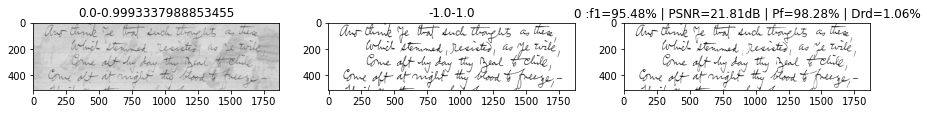

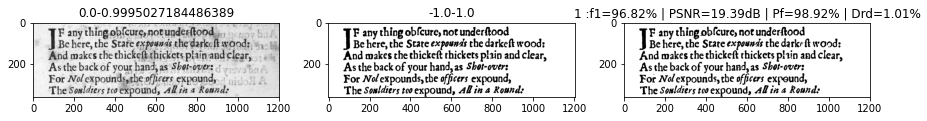

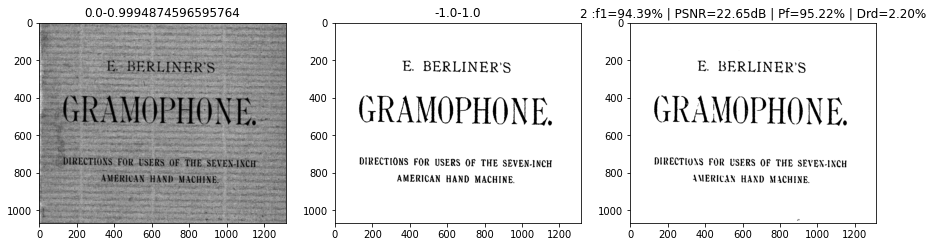

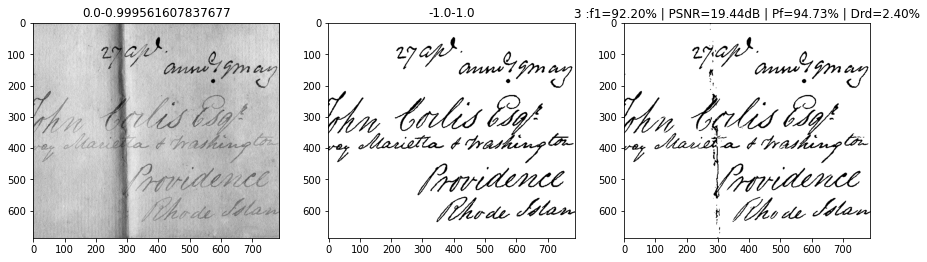

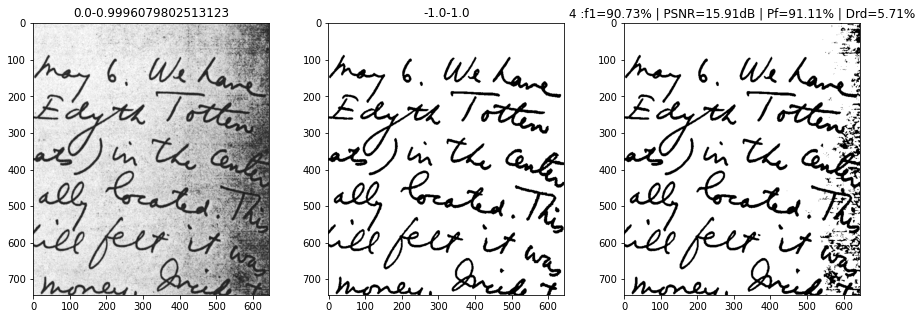

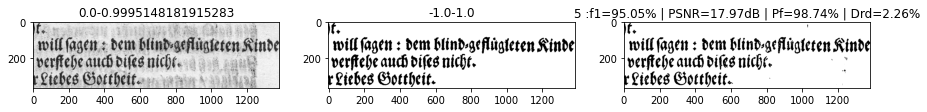

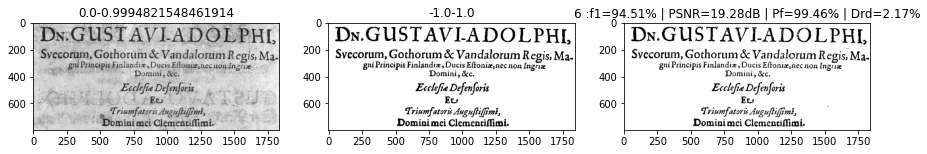

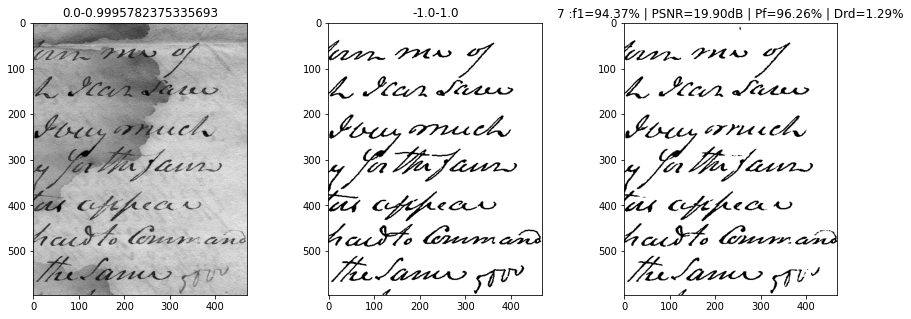

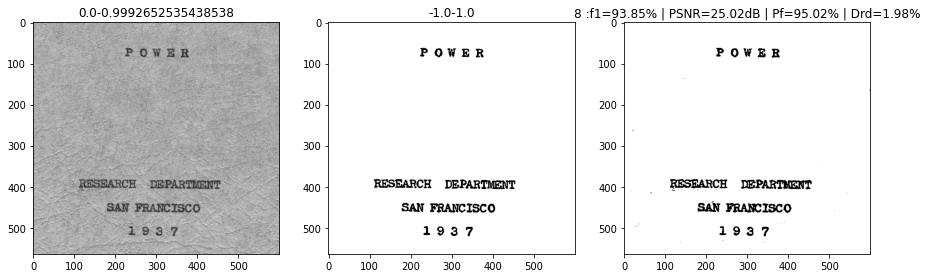

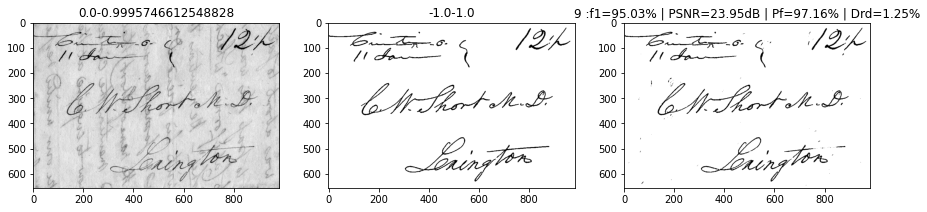

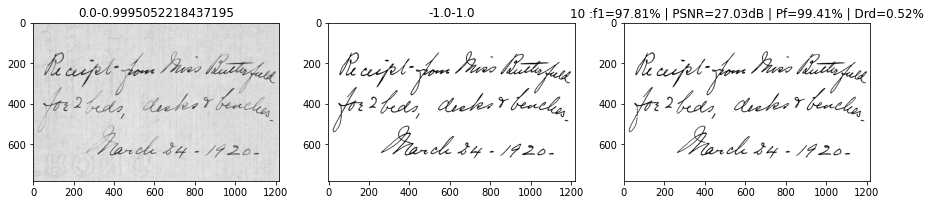

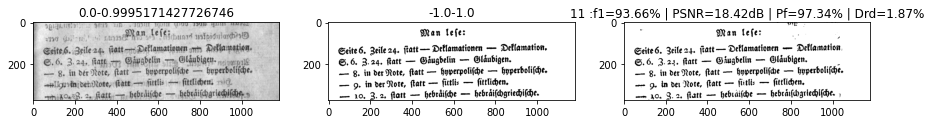

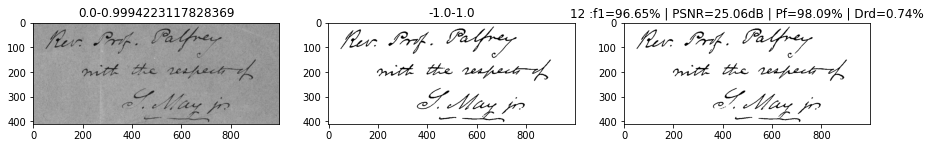

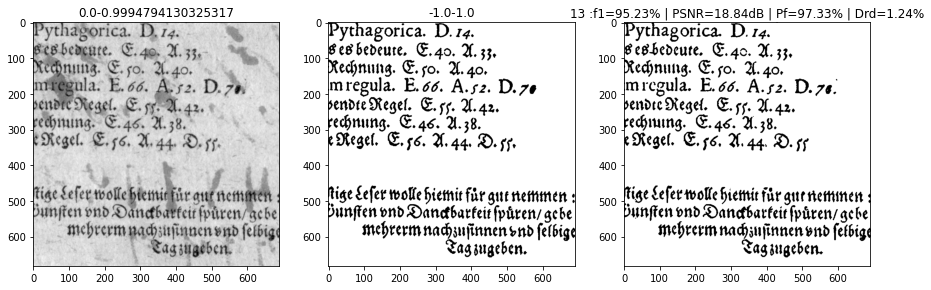

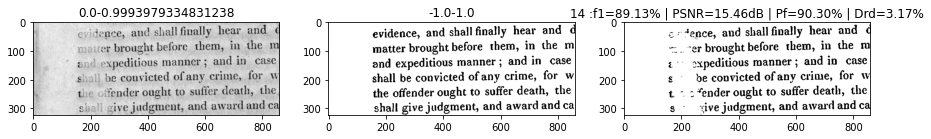

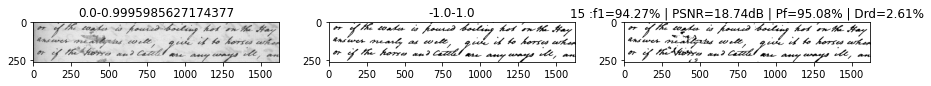

----------------------------------------------------------------------------------------------------
Total average : DIBCO2011 [ 0.94322897 20.55512532  0.96402484  1.96597696]
----------------------------------------------------------------------------------------------------
Total average : DIBCO2014 [ 0.97839459 24.13158967  0.98743749  0.65020778]
----------------------------------------------------------------------------------------------------
Total average : DIBCO2016 [ 0.90257998 18.97295684  0.9526459   3.50556893]


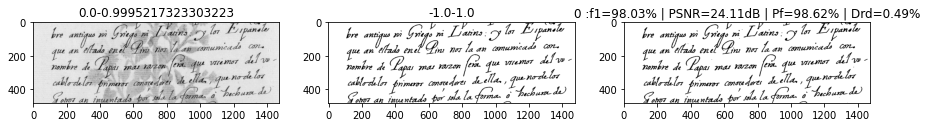

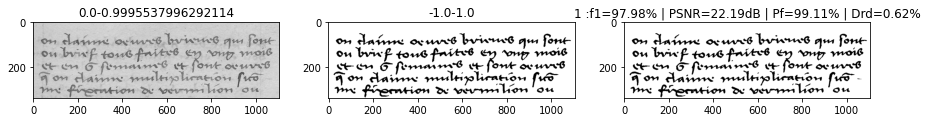

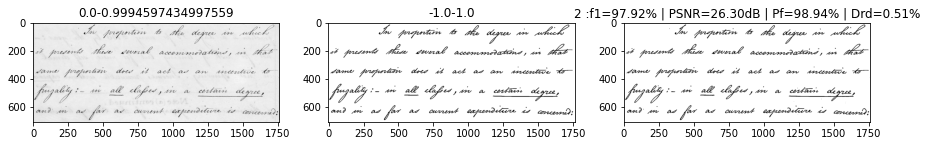

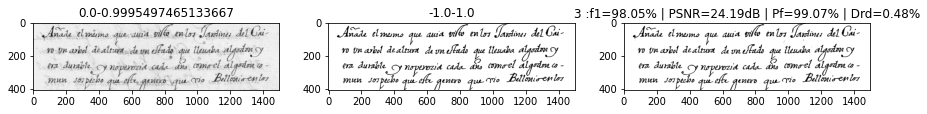

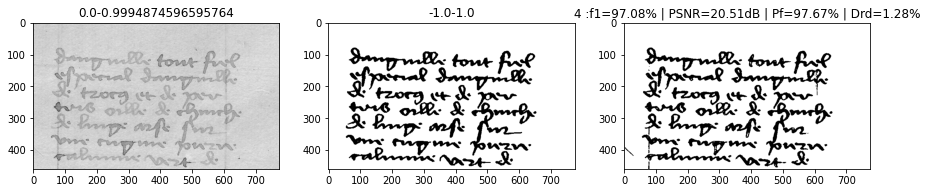

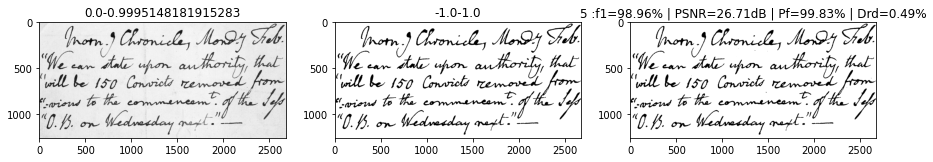

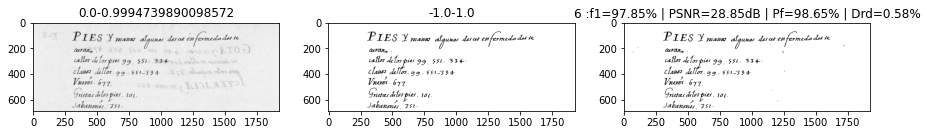

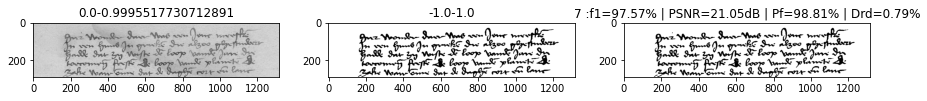

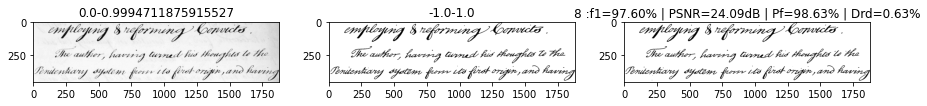

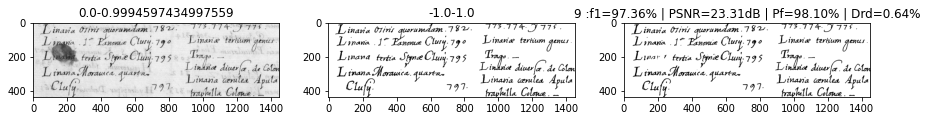

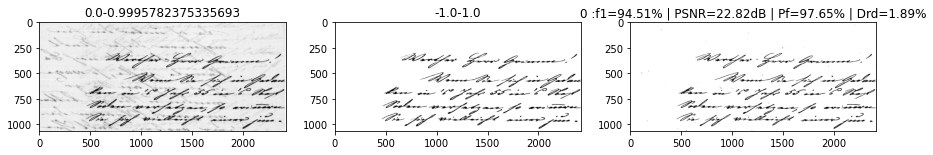

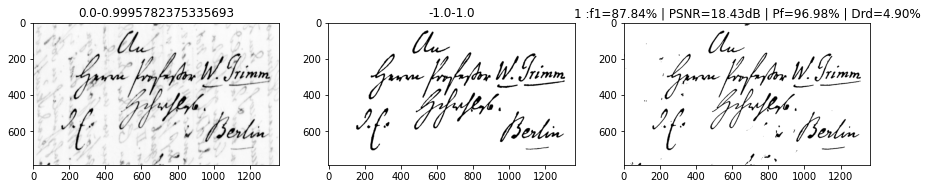

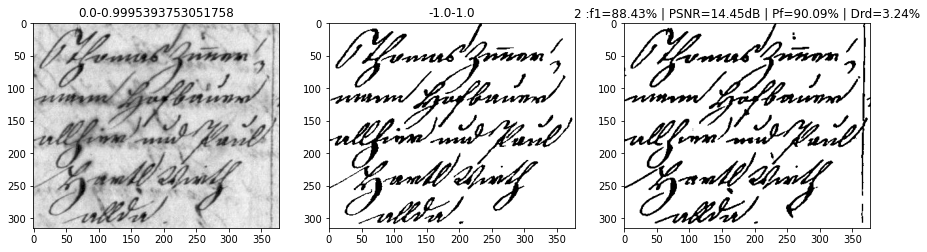

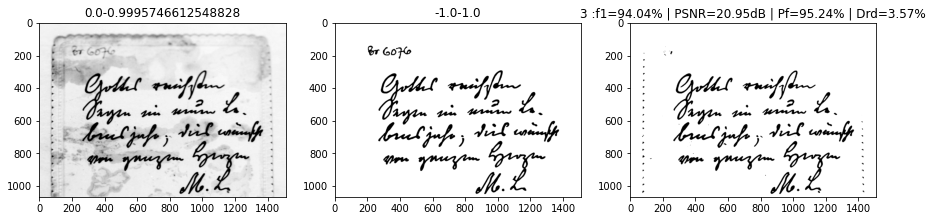

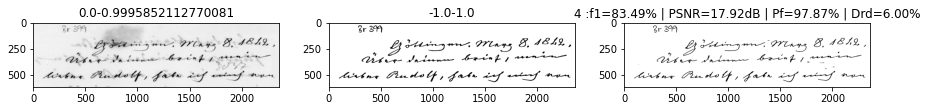

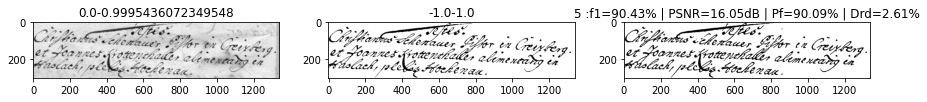

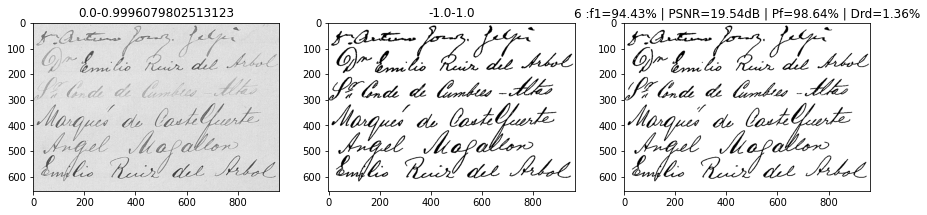

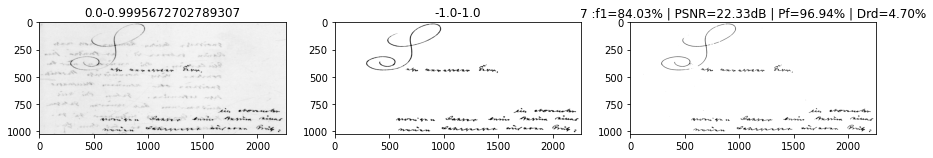

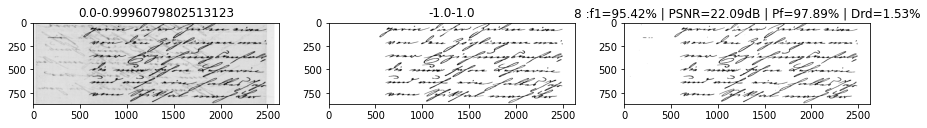

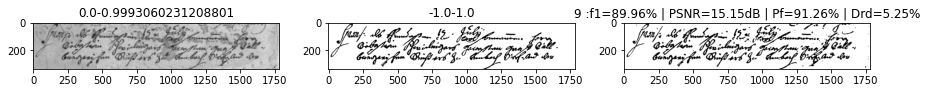

In [4]:
dataset_lut = collect_binarization_by_dataset('Dataset')
test_datasets = ["DIBCO2011","DIBCO2014","DIBCO2016"]
for this in test_datasets :
    all_metrics = []
    test_datagen = DataGenerator(dataset_lut[this], output_shape=None, mode='testing')
    L = len(test_datagen)
    for i in range(L) :
        x, y = test_datagen[i]

        z = net(torch.tensor(np.transpose(x.astype(np.float32), (0, 3, 1, 2))).to(device))
        z = z.cpu().data.numpy()
        pyplot.figure(figsize=(15,5))
        pyplot.subplot(131)
        pyplot.imshow(x[0,...,0], cmap='gray')
        pyplot.title('{}-{}'.format(x.min(), x.max()))
        pyplot.subplot(132)
        pyplot.imshow(y[0,...,0], cmap='gray', vmin=-1, vmax=1)
        pyplot.title('{}-{}'.format(y.min(), y.max()))
        pyplot.subplot(133)
        pyplot.imshow(z[0,...,0]>0, cmap='gray', vmin=0, vmax=1)
        pyplot.title(f'predicted {z.min():.2f} - {z.max():.2f}')
        f1 = Fmeasure(z[0,...,0]>0,y[0,...,0]>0)
        psnr = Psnr(z[0,...,0]>0,y[0,...,0]>0)
        Pf = Pfmeasure(z[0,...,0]>0,y[0,...,0]>0)
        drd = DRD(z[0,...,0]>0,y[0,...,0]>0)
        all_metrics.append([f1, psnr, Pf, drd])
        pyplot.title(f'{i} :f1={f1*100:.2f}% | PSNR={psnr:.2f}dB | Pf={Pf*100:.2f}% | Drd={drd:.2f}%')
        pyplot.show()
    print('-' * 100)
    print("Total average : " +this+" "+ str(np.mean(all_metrics,axis=0)))

In [5]:
from PIL import Image
import requests
def read_image_from_url(url) :
    im = Image.open(requests.get(url, stream=True).raw)
    rgb = np.array(im)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return gray, rgb

def decode_online_image(url, figsize=(10,5)) :
    gray, rgb = read_image_from_url(url)
    pyplot.figure(figsize=figsize)
    pyplot.subplot(121)
    pyplot.imshow(rgb,)
    pyplot.title('original RGB input')
    pyplot.subplot(122)
    x = gray.astype('float32')[None, ..., None]/255.
    z = net(torch.tensor(np.transpose(x.astype(np.float32), (0, 3, 1, 2))).to(device))
    pred = z.cpu().data.numpy()
    pyplot.imshow(pred[0,...,0] > 0, cmap='gray')
    pyplot.title('predicted binary output')
    pyplot.show()

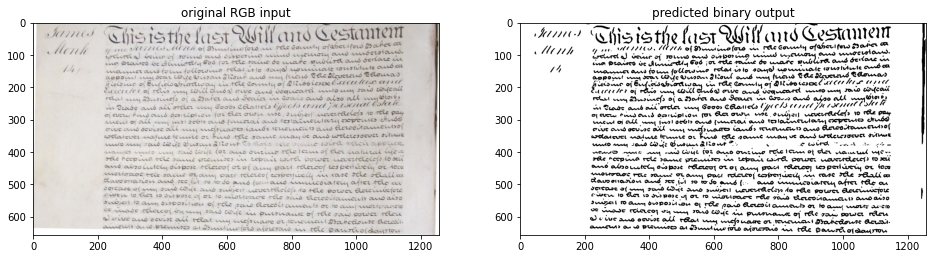

In [6]:
decode_online_image('https://cdn.nationalarchives.gov.uk/blog/wp-content/uploads/2018/03/01144633/PROB-11.2105.1.1.1.jpg',figsize=(16,8))
